# <span style="color:deepskyblue">8.4 커널 PCA </span>    
--- 

고차원 특성 공간에서의 선형 결정 경계는 원본 공간에서는 복잡한 비선형 결정 경계에 해당함  
같은 기법을 PCA에 적용하여 차원 축소를 위한 복잡한 비선형 투영을 수행할 수 있는데 이를 `커널 PCA`라고 함

이 기법은 투영된 후에 샘플의 군집을 유지하거나 꼬인 매니폴드에 가까운 데이터를 펼칠 때 유용

In [1]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [2]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#### 그림8-10 여러 가지 커널의 kPCA를 사용해 2D로 축소

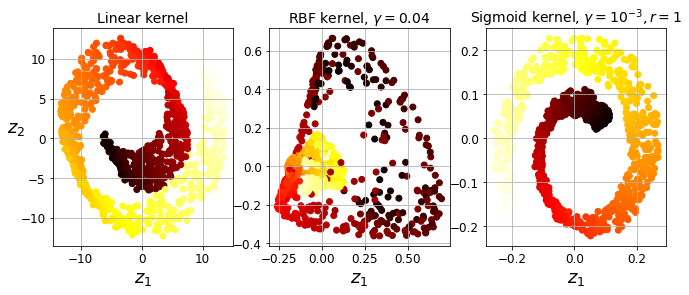

In [4]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components=2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components=2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)


## <span style="color:lightpink">8.4.1 커널 선택과 하이퍼파라미터 튜닝</span>

비지도 학습이라 명확한 기준이 없음

차원 축소는 종종 지도 학습의 전처리 단계로 활용되므로 그리드 탐색을 사용하여 주어진 문제에서 성능이 가장 좋은 커널과  
하이퍼 파라미터를 선택할 수 있음

2차원으로 축소 ==> 로지스틱 ==> GridSearchCV  ==>kPCA의 좋은 커널과 감마 파라미터를 찾음

In [5]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [6]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


완전한 비지도 학습 방법으로 가장 낮은 재구성 오차를 만드는 커널과 하이퍼파라미터 선택

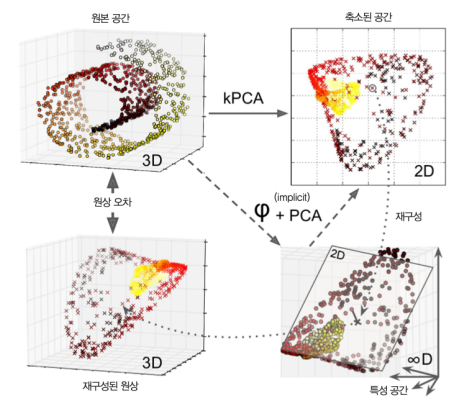

차원 축소된 데이터를 복원하면 원본 공간이 아니라 특성 공간에 놓임==> 무한 차원이기에 포인트와 실제 에러를 계산 불가.  
재구성 원상으로 재구성된 포인트에 가깝게 매핑된 원본 공간의 포인트를 찾기 가능 ==>재구성 원상의 오차를 최소화하는 커널과 하이퍼파라미터 선택.

Scikit-learn에서는 매개변수로 fit_inverse_transform=True로 설정하여 수행

In [7]:
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [8]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

1.0114163551918394e-26

# <span style="color:deepskyblue">8.5 LLE </span>    
--- 

지역 선형 임베딩(Locally Linear Embedding, LLE)는 비선형 차원 축소 기술이지만, 투영에 의존하지 않는 매니폴드 학습

LLE는 각 훈련 샘플이 가장 가까운 이웃에 얼마나 선형적으로 연관되어 있는지 측정하고, 국부적 관계가 가장 잘 보존되는 저차원 표현을 찾음

잡음이 너무 많지 않은 경우 꼬인 매니폴드를 펼치는데 잘 작동

In [9]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [10]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

#### 그림8-12 LLE사용

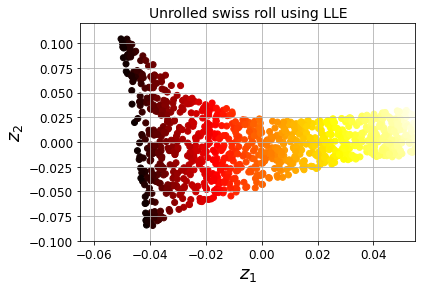

In [11]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

스위스 롤이 완전히 펼쳐졌고 지역적으로는 샘플 간 거리가 잘 보존되어 있음

# <span style="color:deepskyblue">8.6 다른 차원 축소 기법 </span>    
--- 

- 랜덤 투영(Random Projection)  
말 그대로 선형적인 투영을 랜덤하게 하여 데이터를 저차원으로 투영
실제 거리를 잘 보존한다는 것이 수학적으로 증명됨 
차원 축소 품질은 샘플 수와 목표 차원수에 따라 다르며, 초기 차원수에는 의존적이지 않음

- 다차원 스케일링(Multidimensional Scaling, MDS)  
샘플 간의 거리를 보존하면서 차원 축소

- Isomap  
각 샘플을 가장 가까운 이웃과 연결하는 식으로 그래프 생성  
그 후 샘플 간의 지오데식 거리(Geodesic Distance, 두 노드 사이의 최단 경로를 이루는 노드의 수)를 유지하면서 차원 축소

- t-SNE(t-Distributed Stochastic Neighbor Embedding)  
비슷한 샘플은 가까이, 비슷하지 않은 샘플은 멀리 떨어지도록 하면서 차원 축소  
주로 시각화에 많이 이용되며, 특히 고차원 공간에 있는 샘플의 군집을 시각화 할 때 사용

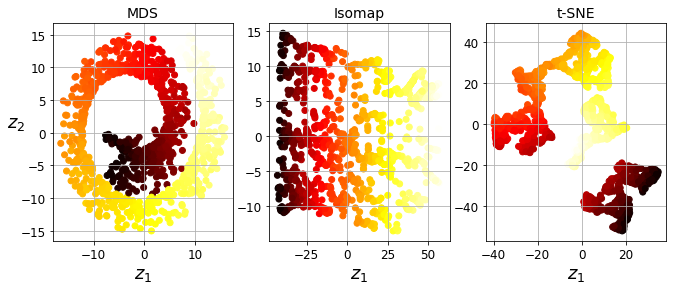

- 선형 판별 분석(Linear Discriminant Analysis, LDA)  
분류 알고리즘이지만, 훈련 과정에서 클래스 사이를 가장 잘 구분하는 축을 학습  
학습된 축은 데이터가 투영되는 초평면을 정의하는데 사용  
투영을 통해 가능한 한 클래스를 멀리 떨어지게 유지시킴 ==> SVM 같은 분류 알고리즘 적용 전 차원 축소에 좋음